In [76]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import requests
import pycountry
import sqlite3
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)


In [5]:
#2.Load WHO API Data

urls = {
    "adult_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_30C",
    "child_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C",
    "adult_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_18C",
    "child_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
}

def load_api(url):
    response = requests.get(url)
    data = response.json()["value"]
    return pd.DataFrame(data)

df_adult_obesity = load_api(urls["adult_obesity"])
df_child_obesity = load_api(urls["child_obesity"])
df_adult_malnutrition = load_api(urls["adult_malnutrition"])
df_child_malnutrition = load_api(urls["child_malnutrition"])


In [6]:
#3.Add Age Group Column

df_adult_obesity["Age_Group"] = "Adult"
df_child_obesity["Age_Group"] = "Child/Adolescent"

df_adult_malnutrition["Age_Group"] = "Adult"
df_child_malnutrition["Age_Group"] = "Child/Adolescent"


In [7]:
#4.Combine Datasets

df_obesity = pd.concat([df_adult_obesity, df_child_obesity], ignore_index=True)
df_malnutrition = pd.concat([df_adult_malnutrition, df_child_malnutrition], ignore_index=True)


In [9]:
print(df_obesity.shape)
print(df_malnutrition.shape)

print(df_obesity["Age_Group"].unique())
print(df_malnutrition["Age_Group"].unique())

(83160, 26)
(83160, 26)
['Adult' 'Child/Adolescent']
['Adult' 'Child/Adolescent']


In [10]:
#5.Filter Years (2012–2022)

df_obesity = df_obesity[(df_obesity["TimeDim"] >= 2012) & (df_obesity["TimeDim"] <= 2022)]
df_malnutrition = df_malnutrition[(df_malnutrition["TimeDim"] >= 2012) & (df_malnutrition["TimeDim"] <= 2022)]


In [11]:
#6.Select & Rename Columns

cols = ["ParentLocation", "Dim1", "TimeDim", "Low", "High", "NumericValue", "SpatialDim", "Age_Group"]

df_obesity = df_obesity[cols].rename(columns={
    "ParentLocation": "Region",
    "Dim1": "Gender",
    "TimeDim": "Year",
    "NumericValue": "Mean_Estimate",
    "Low": "LowerBound",
    "High": "UpperBound",
    "SpatialDim": "Country"
})

df_malnutrition = df_malnutrition[cols].rename(columns={
    "ParentLocation": "Region",
    "Dim1": "Gender",
    "TimeDim": "Year",
    "NumericValue": "Mean_Estimate",
    "Low": "LowerBound",
    "High": "UpperBound",
    "SpatialDim": "Country"
})


In [12]:
#7.Standardize Gender Values

gender_map = {
    "SEX_MLE": "Male",
    "SEX_FMLE": "Female",
    "SEX_BTSX": "Both"
}

df_obesity["Gender"] = df_obesity["Gender"].map(gender_map)
df_malnutrition["Gender"] = df_malnutrition["Gender"].map(gender_map)


In [14]:
df_obesity

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,Age_Group
0,None,Both,2020,7.045677,8.160195,7.587976,WPR,Adult
2,Europe,Female,2021,14.229935,19.655068,16.798417,SVN,Adult
3,Europe,Male,2014,16.816987,22.484732,19.599763,MDA,Adult
5,Europe,Male,2019,17.483680,23.878790,20.532216,BEL,Adult
7,Western Pacific,Both,2022,4.128999,5.799731,4.935368,JPN,Adult
...,...,...,...,...,...,...,...,...
83137,Europe,Both,2020,0.964176,2.197432,1.475931,TJK,Child/Adolescent
83140,Eastern Mediterranean,Female,2012,0.302039,5.872414,1.966190,SOM,Child/Adolescent
83148,Western Pacific,Male,2021,3.325899,34.877816,16.634887,VUT,Child/Adolescent
83151,Africa,Male,2014,0.236481,6.341185,2.032189,MDG,Child/Adolescent


In [16]:
#8.Convert Country Codes to Full Names

special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
    # 'GLOBAL': 'Global',
    # 'AFR': 'Africa',
    # 'EUR': 'Europe',
    # 'SEAR': 'South-East Asia',
    # 'AMR': 'Americas',
    # 'EMR': 'Eastern Mediterranean',
    # 'WPR': 'Western Pacific'
}

def country_name(code):
    if code in special_cases:
        return special_cases[code]
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return code

df_obesity["Country"] = df_obesity["Country"].apply(country_name)
df_malnutrition["Country"] = df_malnutrition["Country"].apply(country_name)
# -------- 3. Final Check --------
print(df_obesity[["Gender", "Country"]].head())
print(df_malnutrition[["Gender", "Country"]].head())

   Gender                 Country
0    Both  Western Pacific Region
2  Female                Slovenia
3    Male    Moldova, Republic of
5    Male                 Belgium
7    Both                   Japan
    Gender             Country
0     Both         Saint Lucia
2   Female               Palau
6   Female             Albania
9     Male  Russian Federation
11    Both             Liberia


In [17]:
# Replace None / NaN with 'Unknown'
df_obesity["Region"] = df_obesity["Region"].fillna("Unknown")
df_malnutrition["Region"] = df_malnutrition["Region"].fillna("Unknown")

In [19]:
df_obesity


,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,Age_Group
0,Unknown,Both,2020,7.045677,8.160195,7.587976,Western Pacific Region,Adult
2,Europe,Female,2021,14.229935,19.655068,16.798417,Slovenia,Adult
3,Europe,Male,2014,16.816987,22.484732,19.599763,"Moldova, Republic of",Adult
5,Europe,Male,2019,17.483680,23.878790,20.532216,Belgium,Adult
7,Western Pacific,Both,2022,4.128999,5.799731,4.935368,Japan,Adult
...,...,...,...,...,...,...,...,...
83137,Europe,Both,2020,0.964176,2.197432,1.475931,Tajikistan,Child/Adolescent
83140,Eastern Mediterranean,Female,2012,0.302039,5.872414,1.966190,Somalia,Child/Adolescent
83148,Western Pacific,Male,2021,3.325899,34.877816,16.634887,Vanuatu,Child/Adolescent
83151,Africa,Male,2014,0.236481,6.341185,2.032189,Madagascar,Child/Adolescent


In [20]:
df_malnutrition

,Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,Age_Group
0,Americas,Both,2018,2.910176,5.165938,3.942757,Saint Lucia,Adult
2,Western Pacific,Female,2018,0.801491,2.616453,1.577565,Palau,Adult
6,Europe,Female,2016,1.432766,2.682612,1.995392,Albania,Adult
9,Europe,Male,2017,1.009803,2.385908,1.618768,Russian Federation,Adult
11,Africa,Both,2016,5.336079,7.676466,6.446506,Liberia,Adult
...,...,...,...,...,...,...,...,...
83147,Americas,Female,2013,2.795499,5.714345,4.140693,Haiti,Child/Adolescent
83149,Europe,Both,2018,5.428173,10.218395,7.574986,Tajikistan,Child/Adolescent
83150,Western Pacific,Both,2016,0.621721,3.507061,1.703645,Papua New Guinea,Child/Adolescent
83156,Western Pacific,Female,2020,0.064152,2.810176,0.734066,Samoa,Child/Adolescent


In [23]:
#9.Feature Engineering

df_obesity["CI_Width"] = df_obesity["UpperBound"] - df_obesity["LowerBound"]
df_malnutrition["CI_Width"] = df_malnutrition["UpperBound"] - df_malnutrition["LowerBound"]

def obesity_level(x):
    if x >= 30:
        return "High"
    elif 25 <=x< 30:
        return "Moderate"
    else:
        return "Low"

def malnutrition_level(x):
    if x >= 20:
        return "High"
    elif 10<=x< 20:
        return "Moderate"
    else:
        return "Low"

df_obesity["Obesity_Level"] = df_obesity["Mean_Estimate"].apply(obesity_level)
df_malnutrition["Malnutrition_Level"] = df_malnutrition["Mean_Estimate"].apply(malnutrition_level)
# -------- 4. Final Check --------
print(df_obesity[["Mean_Estimate", "CI_Width", "Obesity_Level"]].head())
print(df_malnutrition[["Mean_Estimate", "CI_Width", "Malnutrition_Level"]].head())


   Mean_Estimate  CI_Width Obesity_Level
0       7.587976  1.114518           Low
2      16.798417  5.425133           Low
3      19.599763  5.667745           Low
5      20.532216  6.395110           Low
7       4.935368  1.670732           Low
    Mean_Estimate  CI_Width Malnutrition_Level
0        3.942757  2.255761                Low
2        1.577565  1.814962                Low
6        1.995392  1.249847                Low
9        1.618768  1.376106                Low
11       6.446506  2.340387                Low


In [24]:
#Final verification and export to CSV (Power BI ready)

# -------- 1. Check final columns --------
print("Obesity columns:", df_obesity.columns)
print("Malnutrition columns:", df_malnutrition.columns)

# -------- 2. Check column count --------
print("Obesity column count:", df_obesity.shape[1])
print("Malnutrition column count:", df_malnutrition.shape[1])

# -------- 3. Preview final data --------
print(df_obesity.head())
print(df_malnutrition.head())

# -------- 4. Export to CSV --------
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

print("CSV files exported successfully!")

Obesity columns: Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'Age_Group', 'CI_Width', 'Obesity_Level'],
      dtype='object')
Malnutrition columns: Index(['Region', 'Gender', 'Year', 'LowerBound', 'UpperBound', 'Mean_Estimate',
       'Country', 'Age_Group', 'CI_Width', 'Malnutrition_Level'],
      dtype='object')
Obesity column count: 10
Malnutrition column count: 10
            Region  Gender  Year  LowerBound  UpperBound  Mean_Estimate  \
0          Unknown    Both  2020    7.045677    8.160195       7.587976   
2           Europe  Female  2021   14.229935   19.655068      16.798417   
3           Europe    Male  2014   16.816987   22.484732      19.599763   
5           Europe    Male  2019   17.483680   23.878790      20.532216   
7  Western Pacific    Both  2022    4.128999    5.799731       4.935368   

                  Country Age_Group  CI_Width Obesity_Level  
0  Western Pacific Region     Adult  1.114518           Low  


In [25]:
df_obesity.to_csv("df_obesity_final.csv", index=False)
df_malnutrition.to_csv("df_malnutrition_final.csv", index=False)

In [27]:
df_obesity.to_csv(r"C:\nutrition_paradox\df_malnutrition_final.csv", index=False)
df_malnutrition.to_csv(r"C:\nutrition_paradox\df_malnutrition_final.csv", index=False)

print("CSV saved on Desktop")

CSV saved on Desktop


In [29]:
conn = sqlite3.connect("nutrition_db")
cursor = conn.cursor()

In [30]:
# save dataframes into sqlite tables

df_obesity.to_sql(
    "obesity_powerbi",
    conn,
    if_exists="replace",
    index=False
)

df_malnutrition.to_sql(
    "malnutrition_powerbi",
    conn,
    if_exists="replace",
    index=False
)

print("SQLite tables created successfully")

SQLite tables created successfully


In [31]:
pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)

,name
0,obesity_powerbi
1,malnutrition_powerbi


In [33]:
# Insert rows into obesity_powerbi using iterrows()

for _, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity_powerbi (
            Country,
            Region,
            Year,
            Gender,
            age_group,
            Mean_Estimate,
            CI_Width,
            Obesity_Level
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row["Country"],
        row["Region"],
        row["Year"],
        row["Gender"],
        row["Age_Group"],
        row["Mean_Estimate"],
        row["CI_Width"],
        row["Obesity_Level"]
    ))

conn.commit()

In [34]:
# Insert rows into malnutrition_powerbi using iterrows()

for _, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition_powerbi (
            Country,
            Region,
            Year,
            Gender,
            age_group,
            Mean_Estimate,
            CI_Width,
            Malnutrition_Level
        )
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row["Country"],
        row["Region"],
        row["Year"],
        row["Gender"],
        row["Age_Group"],
        row["Mean_Estimate"],
        row["CI_Width"],
        row["Malnutrition_Level"]
    ))

conn.commit()

In [35]:
# Verify counts
pd.read_sql("SELECT COUNT(*) FROM obesity_powerbi", conn)
pd.read_sql("SELECT COUNT(*) FROM malnutrition_powerbi", conn)

,COUNT(*)
0,55440


In [38]:
# Query 1: Top 5 regions with the highest average obesity levels in 2022

q1 = """
SELECT Region, AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Year = 2022
GROUP BY Region
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q1 = pd.read_sql(q1, conn)
df_q1


,Region,avg_obesity
0,Western Pacific,22.639636
1,Americas,21.213601
2,Eastern Mediterranean,18.126910
3,Europe,12.987338
4,Unknown,11.462648


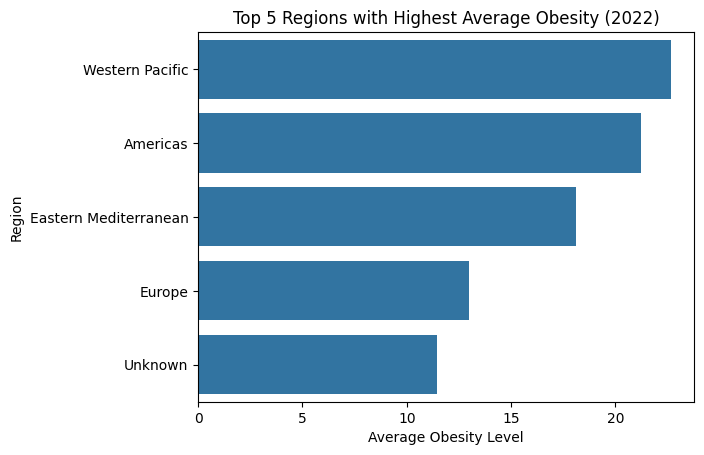

In [39]:
# Seaborn visualization for Query 1

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.barplot(
    data=df_q1,
    x="avg_obesity",
    y="Region"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Region")
plt.title("Top 5 Regions with Highest Average Obesity (2022)")
plt.show()

In [40]:
# Query 2: Top 5 countries with highest obesity estimates

q2 = """
SELECT Country,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Country
ORDER BY avg_obesity DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)
df_q2

,Country,avg_obesity
0,Niue,40.664873
1,Cook Islands,39.917173
2,Nauru,38.512100
3,Tokelau,37.960966
4,American Samoa,36.892015


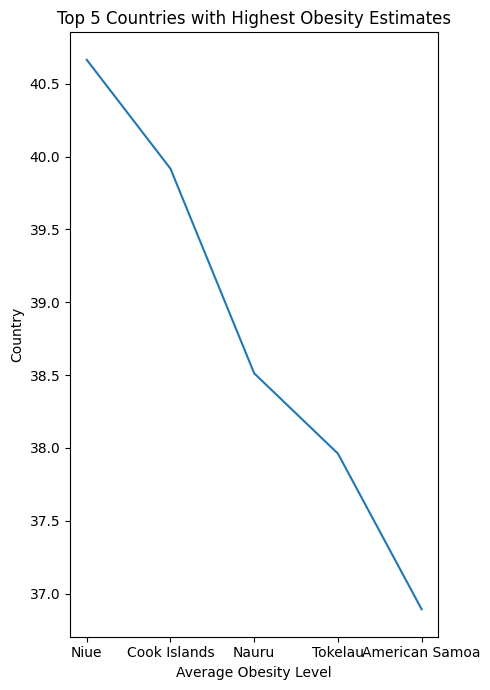

In [41]:
# Seaborn visualization for Query 2

plt.figure(figsize=(5, 7))
sns.lineplot(
    data=df_q2,
    y="avg_obesity",
    x="Country"
)

plt.xlabel("Average Obesity Level")
plt.ylabel("Country")
plt.title("Top 5 Countries with Highest Obesity Estimates")
plt.tight_layout()
plt.show()

In [45]:
# Query 3: Obesity trend in India over the years 2012 to 2022

q3 = """
SELECT Year,
       AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Country = 'India'
GROUP BY Year
ORDER BY Year;
"""
df_q3 = pd.read_sql(q3, conn)
df_q3


,Year,avg_obesity
0,2012,2.473178
1,2013,2.634653
2,2014,2.798749
3,2015,2.972813
4,2016,3.159576
5,2017,3.362175
6,2018,3.579292
7,2019,3.809013
8,2020,4.051149
9,2021,4.307816


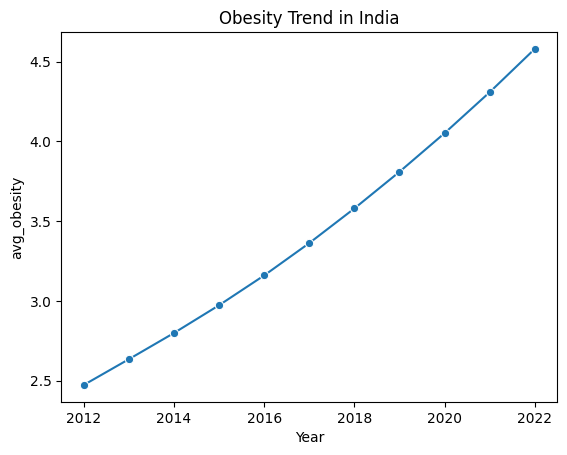

In [46]:
sns.lineplot(data=df_q3, x="Year", y="avg_obesity", marker="o")
plt.title("Obesity Trend in India")
plt.show()

In [47]:
#Query 4: Average obesity by gender (Male, Female, Both)

import seaborn as sns
import matplotlib.pyplot as plt

query_gender = """
SELECT
    Gender,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Gender IN ('Male', 'Female', 'Both')
GROUP BY Gender
ORDER BY avg_obesity DESC;
"""

df_gender = pd.read_sql(query_gender, conn)
df_gender

,Gender,avg_obesity
0,Both,12.781969
1,Male,12.776696
2,Female,12.724456


C:\Users\rvdhi\AppData\Local\Temp\ipykernel_15304\3630530138.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


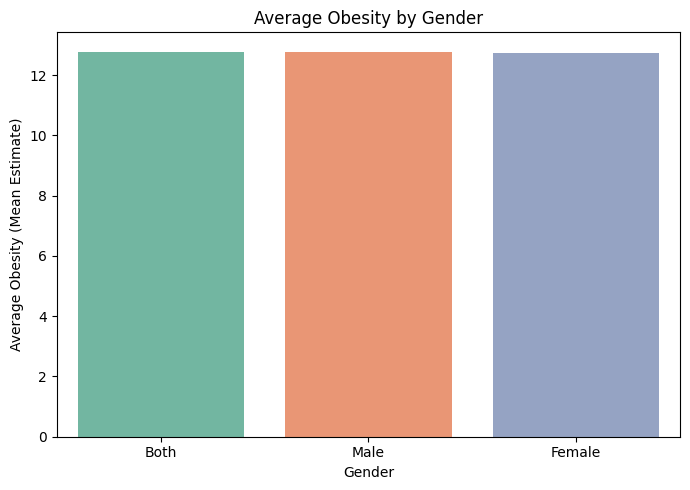

In [48]:
plt.figure(figsize=(7,5))

sns.barplot(
    data=df_gender,
    x="Gender",
    y="avg_obesity",
    palette="Set2"
)

plt.title("Average Obesity by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Obesity (Mean Estimate)")
plt.tight_layout()
plt.show()

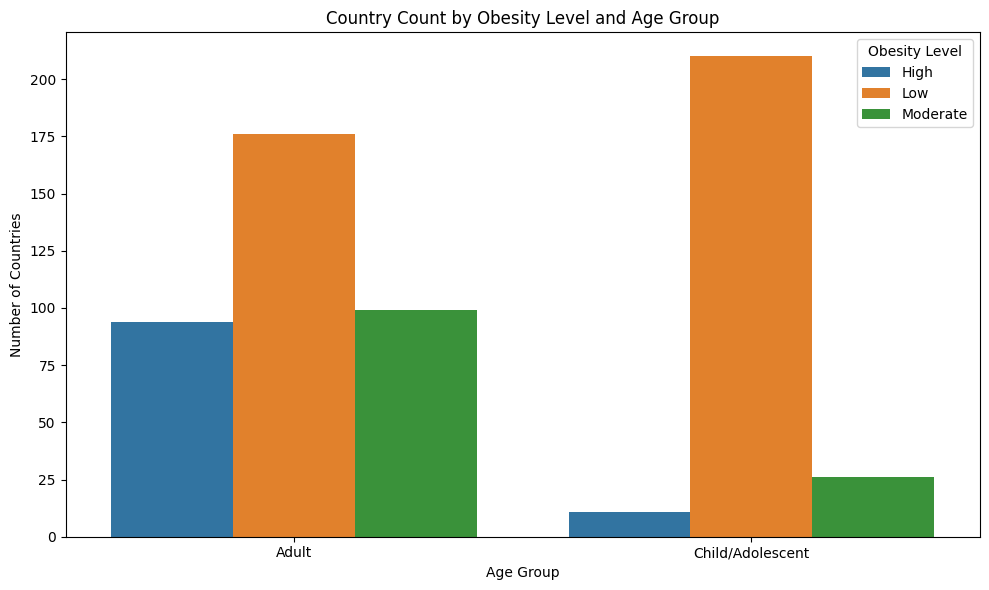

In [50]:
# Query 5: Country count by obesity level category and age group

query_5 = """
SELECT
    Obesity_Level,
    age_group,
    COUNT(DISTINCT Country) AS country_count
FROM obesity_powerbi
GROUP BY Obesity_Level, age_group;
"""

df_q5 = pd.read_sql(query_5, conn)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q5,
    x="Age_Group",
    y="country_count",
    hue="Obesity_Level"
)

plt.title("Country Count by Obesity Level and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Countries")
plt.legend(title="Obesity Level")
plt.tight_layout()
plt.show()


C:\Users\rvdhi\AppData\Local\Temp\ipykernel_15304\3486007013.py:25: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:steelblue'` for the same effect.

  sns.barplot(


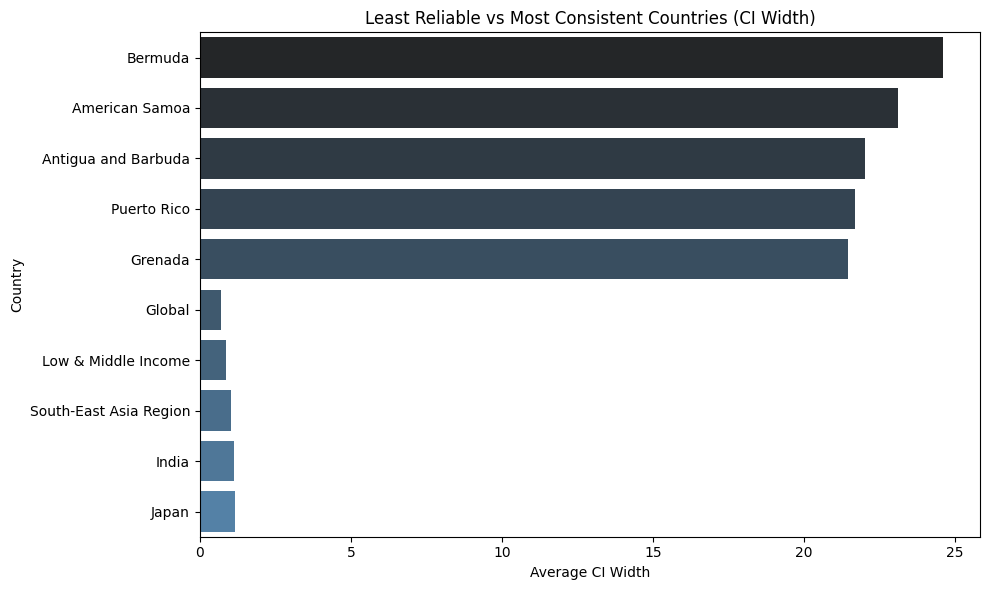

In [ ]:
# Query 6:
# Top 5 least reliable countries (highest avg CI_Width)
# Top 5 most consistent countries (lowest avg CI_Width)

query_6 = """
SELECT
    Country,
    AVG(CI_Width) AS avg_ci_width
FROM obesity_powerbi
GROUP BY Country
"""

df_q6 = pd.read_sql(query_6, conn)

# Top 5 highest CI_Width (least reliable)
top_5_high_ci = df_q6.sort_values("avg_ci_width", ascending=False).head(5)

# Top 5 lowest CI_Width (most consistent)
top_5_low_ci = df_q6.sort_values("avg_ci_width", ascending=True).head(5)

# Combine both
df_q6_plot = pd.concat([top_5_high_ci, top_5_low_ci])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_q6_plot,
    x="avg_ci_width",
    y="Country",
    hue="Country",
    color="steelblue",  
    legend=False
)

plt.title("Least Reliable vs Most Consistent Countries (CI Width)")
plt.xlabel("Average CI Width")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


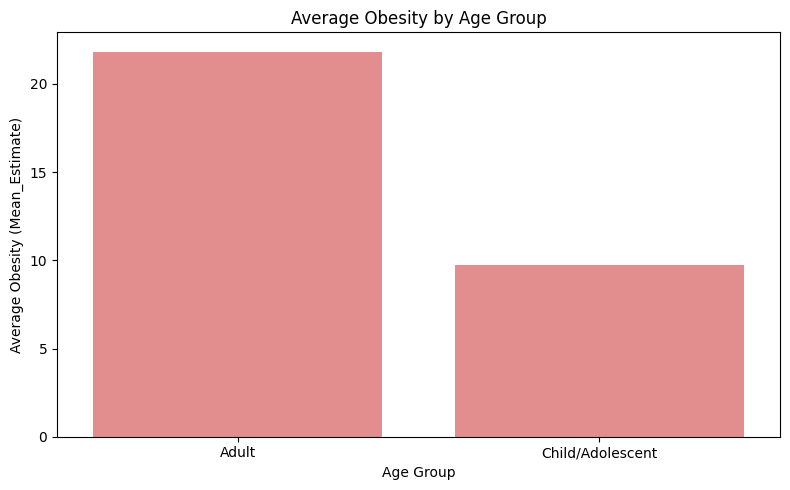

In [60]:
# Query 7: Average obesity by age group

query_7 = """
SELECT
    age_group,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY age_group
ORDER BY avg_obesity DESC;
"""

df_q7 = pd.read_sql(query_7, conn)

# Seaborn bar plot

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_q7,
    x="Age_Group",
    y="avg_obesity",
    color="lightcoral"   
)

plt.title("Average Obesity by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Obesity (Mean_Estimate)")
plt.tight_layout()
plt.show()


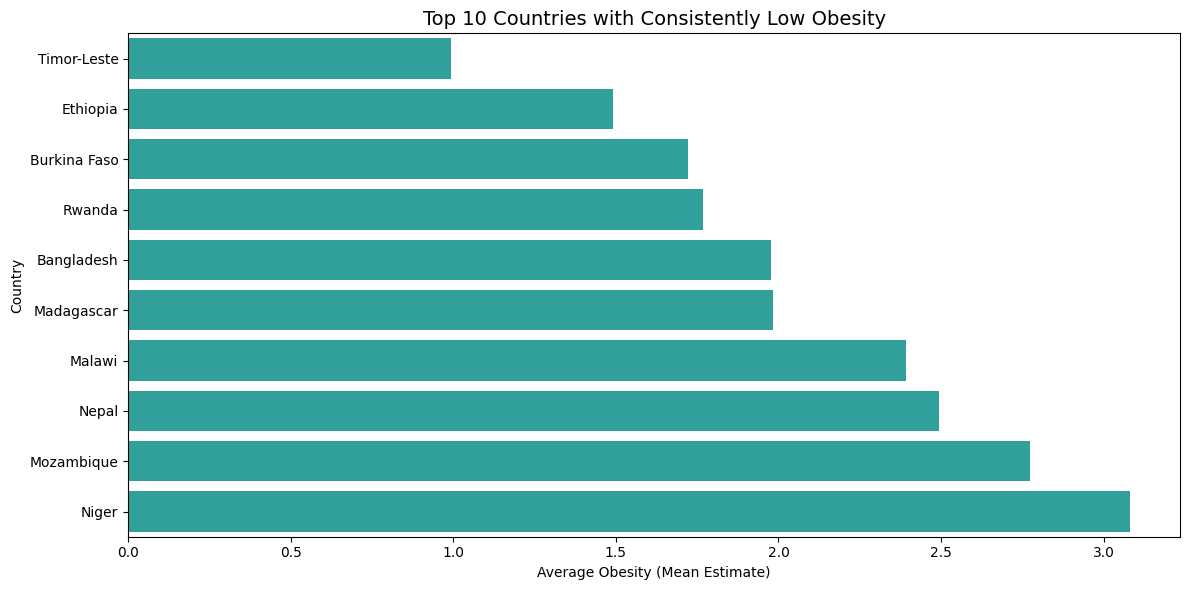

In [ ]:
# Query 8: Top 10 Countries with consistent low obesity (low average + low CI)

query_8_sql = """
SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity,
    AVG(CI_Width) AS avg_ci
FROM obesity_powerbi
GROUP BY Country
HAVING avg_obesity < 10 AND avg_ci < 5
ORDER BY avg_obesity ASC
LIMIT 10;
"""

query_8 = pd.read_sql(query_8_sql, conn)

#Horizontal Bar Chart

plt.figure(figsize=(12, 6))

sns.barplot(
    data=query_8,
    x="avg_obesity",
    y="Country",
    color="lightseagreen"
)

plt.title("Top 10 Countries with Consistently Low Obesity", fontsize=14)
plt.xlabel("Average Obesity (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()


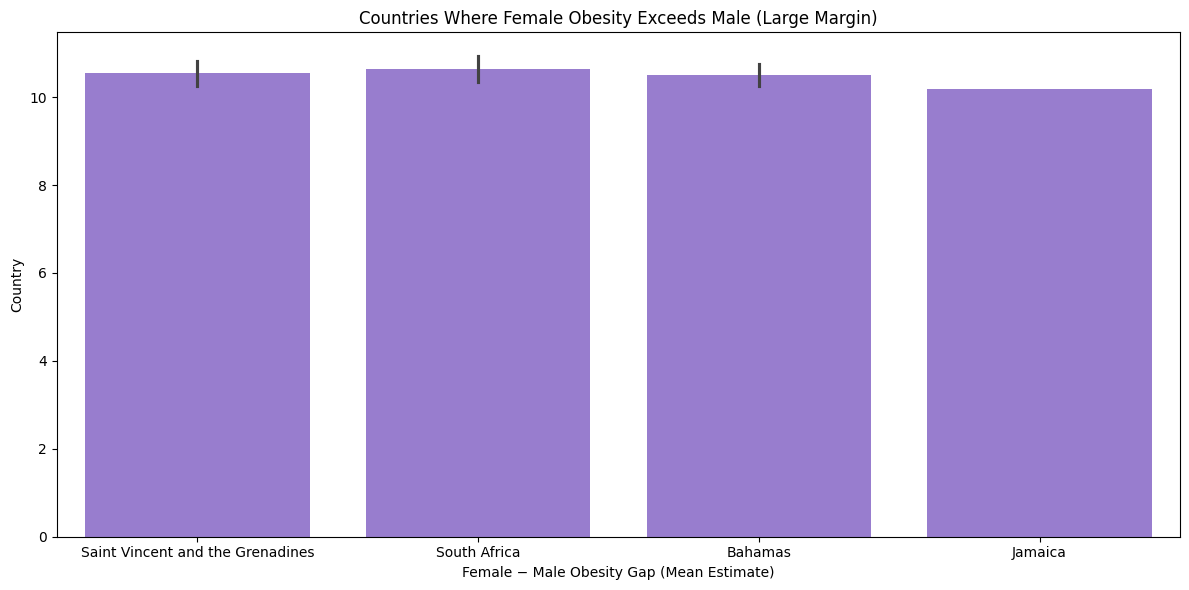

In [62]:
# Query 9: Countries where female obesity exceeds male obesity by a large margin (same year)

query_9 = """
SELECT
    Country,
    Year,
    AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) AS female_obesity,
    AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END) AS male_obesity,
    (AVG(CASE WHEN Gender = 'Female' THEN Mean_Estimate END) -
     AVG(CASE WHEN Gender = 'Male' THEN Mean_Estimate END)) AS obesity_gap
FROM obesity_powerbi
GROUP BY Country, Year
HAVING obesity_gap IS NOT NULL
   AND obesity_gap > 5
ORDER BY obesity_gap DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)

# Plot using Seaborn

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_q9,
    x="Country",
    y="obesity_gap",
    color="mediumpurple"
)

plt.title("Countries Where Female Obesity Exceeds Male (Large Margin)")
plt.xlabel("Female − Male Obesity Gap (Mean Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()

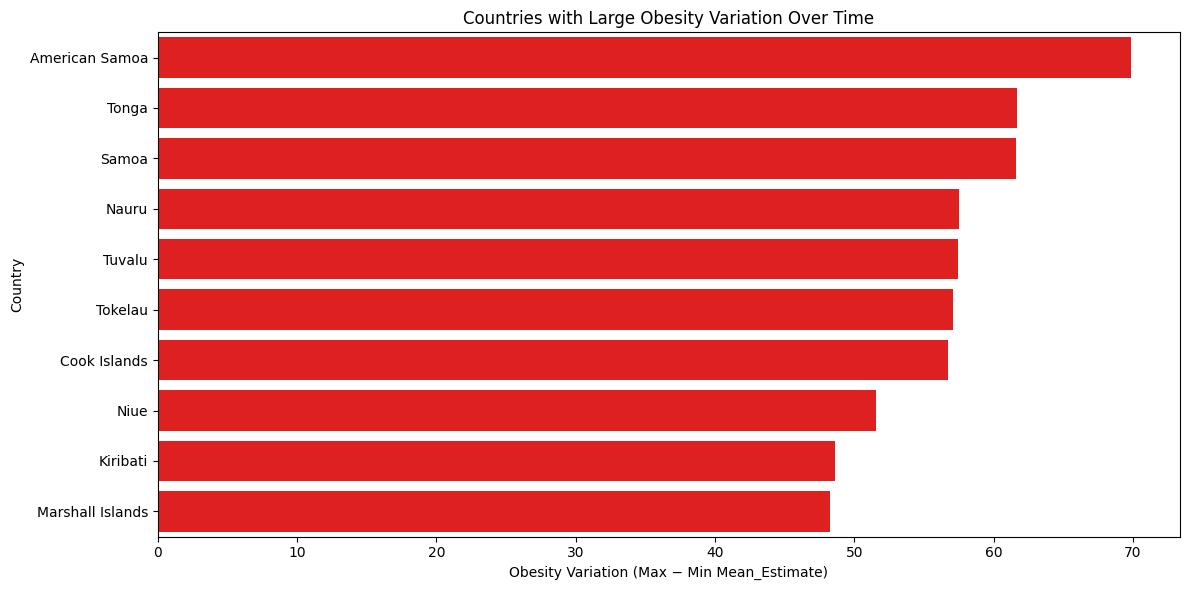

In [64]:
# Query 9 (Modified):
# Countries with large obesity variation over years (max - min)

query_9 = """
SELECT
    Country,
    MAX(Mean_Estimate) - MIN(Mean_Estimate) AS obesity_variation
FROM obesity_powerbi
GROUP BY Country
HAVING obesity_variation > 5
ORDER BY obesity_variation DESC
LIMIT 10;
"""

df_q9 = pd.read_sql(query_9, conn)

plt.figure(figsize=(12,6))

sns.barplot(
    data=df_q9,
    y="Country",
    x="obesity_variation",
    color="red"
)

plt.title("Countries with Large Obesity Variation Over Time")
plt.xlabel("Obesity Variation (Max − Min Mean_Estimate)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()

In [65]:
# Query 10:
# Global average obesity percentage per year

query_10 = """
SELECT
    Year,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Year
ORDER BY Year;
"""

df_q10 = pd.read_sql(query_10, conn)
df_q10

,Year,avg_obesity
0,2012,11.061969
1,2013,11.359637
2,2014,11.670343
3,2015,11.994231
4,2016,12.333907
5,2017,12.689997
6,2018,13.060296
7,2019,13.444604
8,2020,13.843002
9,2021,14.250923


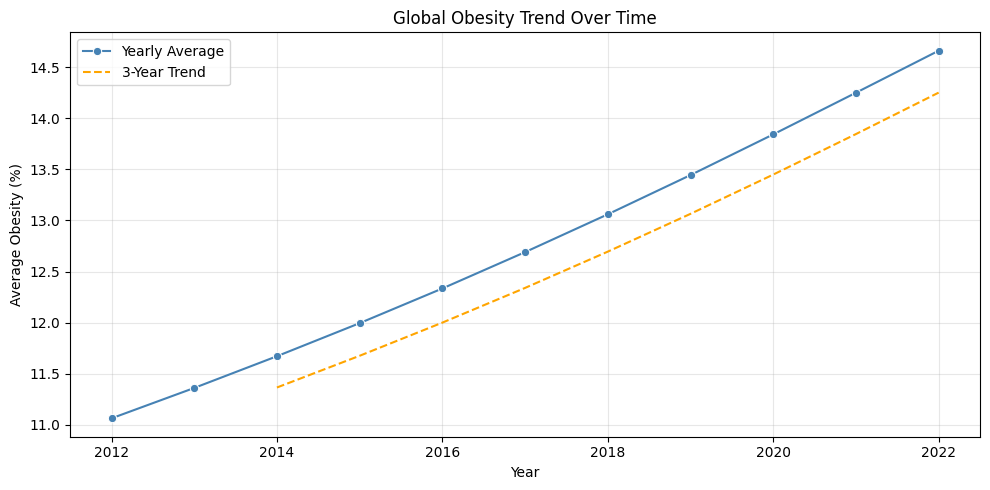

In [66]:
df_q10["rolling_avg"] = df_q10["avg_obesity"].rolling(3).mean()

plt.figure(figsize=(10, 5))

sns.lineplot(
    data=df_q10,
    x="Year",
    y="avg_obesity",
    marker="o",
    label="Yearly Average",
    color="steelblue"
)

sns.lineplot(
    data=df_q10,
    x="Year",
    y="rolling_avg",
    linestyle="--",
    label="3-Year Trend",
    color="orange"
)

plt.title("Global Obesity Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Average Obesity (%)")

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
# World map data: Average obesity by country

q_map_obesity = """
SELECT
    Country,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
GROUP BY Country;
"""

df_map = pd.read_sql(q_map_obesity, conn)
df_map.head()

,Country,avg_obesity
0,Afghanistan,7.763365
1,Africa,4.672290
2,Albania,10.947071
3,Algeria,15.051907
4,American Samoa,36.892015


In [79]:
#To visualize country-wise obesity levels geographically, helping identify regional and global patterns.

import plotly.express as px
import plotly.io as pio

pio.renderers.default = "browser"

fig = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="avg_obesity",
    color_continuous_scale="Reds",
    title="Global Average Obesity Levels by Country",
    labels={"avg_obesity": "Average Obesity (%)"}
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    ),
    coloraxis_colorbar=dict(title="Obesity (%)")
)

fig.show()



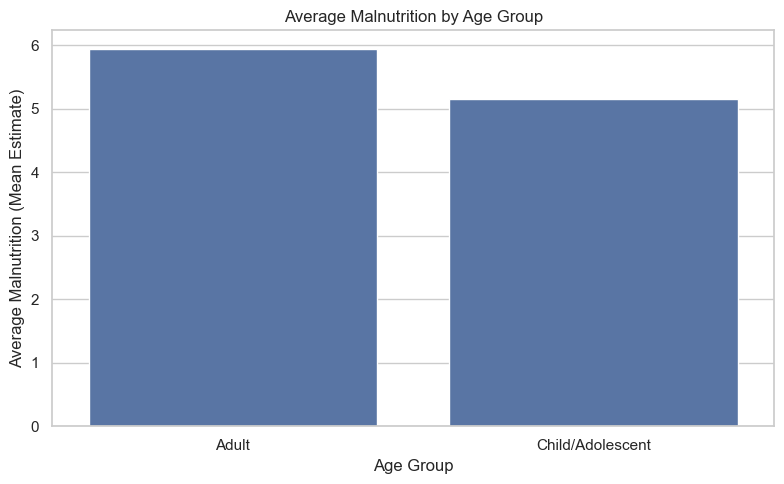

In [81]:
#Malnutrition
     

# Query 1: Average malnutrition by age_group

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

q1 = """
SELECT age_group, AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY age_group
ORDER BY avg_malnutrition DESC;
"""

df_q1 = pd.read_sql(q1, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q1,
    x="Age_Group",
    y="avg_malnutrition"
)

plt.title("Average Malnutrition by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()

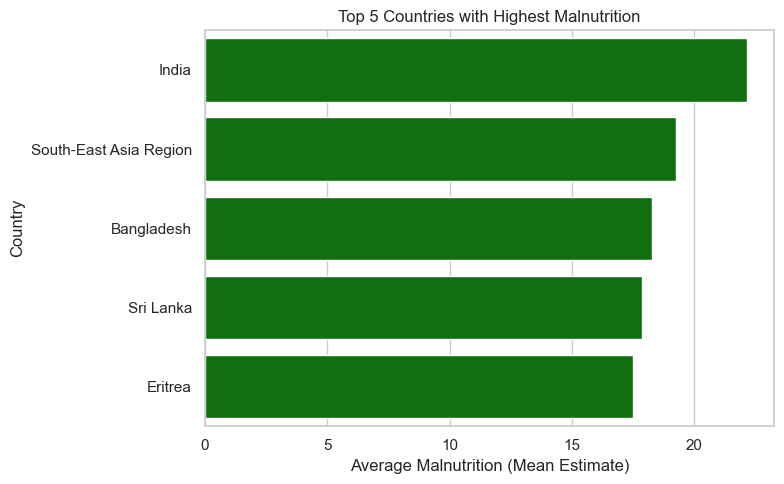

In [85]:
# Query 2: Top 5 countries with highest malnutrition (mean_estimate)

q2 = """
SELECT
    Country,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Country
ORDER BY avg_malnutrition DESC
LIMIT 5;
"""

df_q2 = pd.read_sql(q2, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q2,
    x="avg_malnutrition",
    y="Country",
    color="green"
)

plt.title("Top 5 Countries with Highest Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [88]:
#Query 3: Malnutrition trend in African region over the years

q_africa = """
SELECT
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Region = 'Africa'
GROUP BY Year
ORDER BY Year;
"""

df_africa = pd.read_sql(q_africa, conn)
df_africa.head()


,Year,avg_malnutrition
0,2012,8.849655
1,2013,8.749857
2,2014,8.662762
3,2015,8.587719
4,2016,8.523125


In [ ]:
fig = px.area(
    df_africa,
    x="Year",
    y="avg_malnutrition",
    title="Malnutrition Trend in African Region Over the Years",
    labels={
        "avg_malnutrition": "Average Malnutrition (%)",
        "Year": "Year"
    }
)

fig.update_traces(
    mode="lines+markers",
    line=dict(width=3),
    marker=dict(size=6)
)

fig.update_layout(
    template="plotly_white",
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    hovermode="x unified"
)

fig.show()


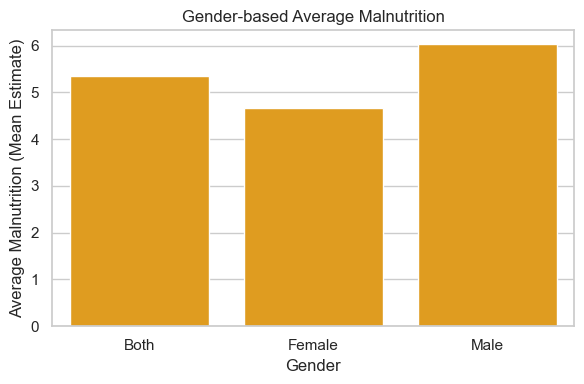

In [91]:
# Query 4: Gender-based average malnutrition

q4 = """
SELECT
    Gender,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Gender;
"""

df_q4 = pd.read_sql(q4, conn)

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_q4,
    x="Gender",
    y="avg_malnutrition",
    color="orange"
)

plt.title("Gender-based Average Malnutrition")
plt.xlabel("Gender")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()

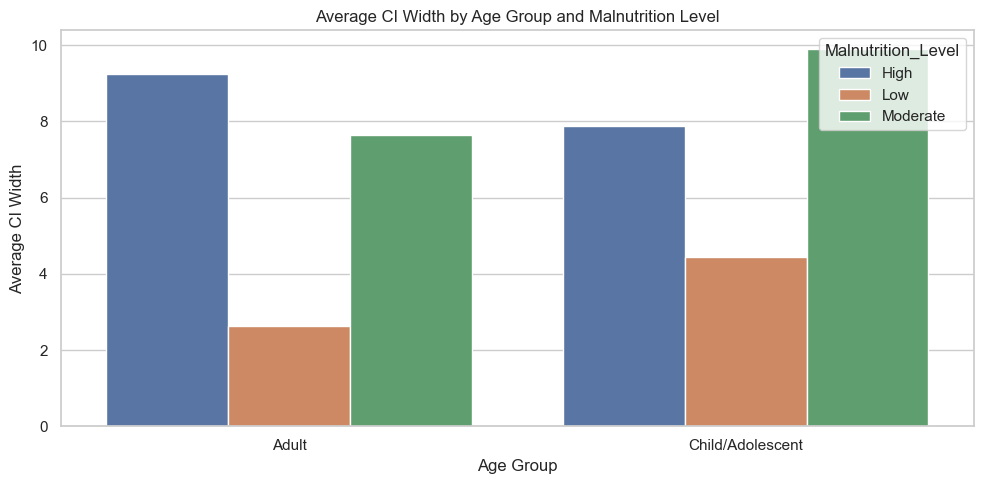

In [93]:
# Query 5: Malnutrition level-wise average CI_Width by age_group (FIXED)

q5 = """
SELECT
    age_group,
    Malnutrition_Level,
    AVG(CI_Width) AS avg_ci_width
FROM malnutrition_powerbi
GROUP BY age_group, Malnutrition_Level
ORDER BY age_group;
"""

df_q5 = pd.read_sql(q5, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q5,
    x="Age_Group",
    y="avg_ci_width",
    hue="Malnutrition_Level"
)

plt.title("Average CI Width by Age Group and Malnutrition Level")
plt.xlabel("Age Group")
plt.ylabel("Average CI Width")
plt.tight_layout()
plt.show()

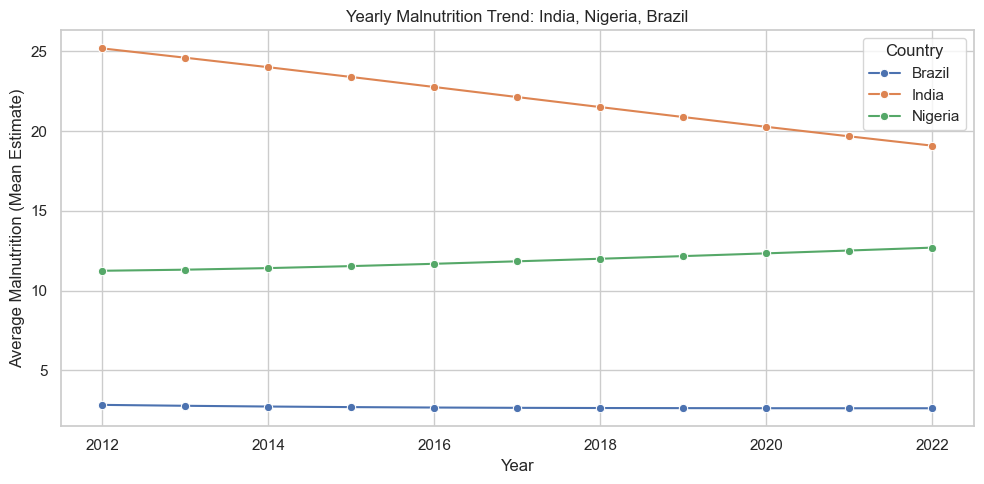

In [94]:

# Query 6: Yearly malnutrition change in India, Nigeria, Brazil

q6 = """
SELECT
    Country,
    Year,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
"""

df_q6 = pd.read_sql(q6, conn)

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_q6,
    x="Year",
    y="avg_malnutrition",
    hue="Country",
    marker="o"
)

plt.title("Yearly Malnutrition Trend: India, Nigeria, Brazil")
plt.xlabel("Year")
plt.ylabel("Average Malnutrition (Mean Estimate)")
plt.tight_layout()
plt.show()

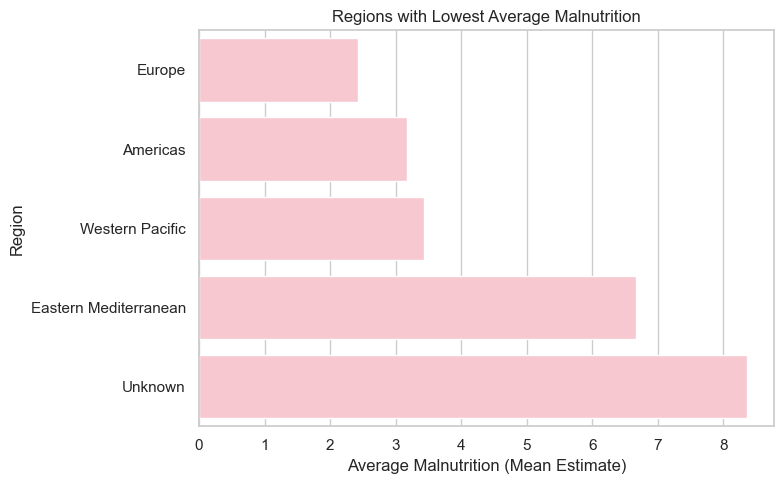

In [97]:
# Query 7: Regions with lowest malnutrition averages

q7 = """
SELECT
    Region,
    AVG(mean_estimate) AS avg_malnutrition
FROM malnutrition_powerbi
GROUP BY Region
ORDER BY avg_malnutrition ASC
LIMIT 5;
"""

df_q7 = pd.read_sql(q7, conn)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_q7,
    x="avg_malnutrition",
    y="Region",
    color="pink"
)

plt.title("Regions with Lowest Average Malnutrition")
plt.xlabel("Average Malnutrition (Mean Estimate)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

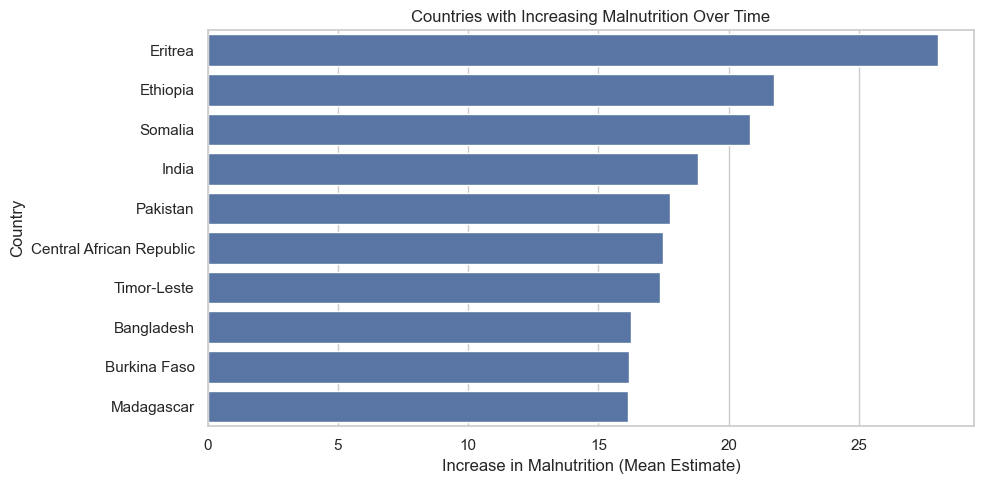

In [98]:
# Query 8: Countries with increasing malnutrition over time

q8 = """
SELECT
    Country,
    MIN(mean_estimate) AS early_malnutrition,
    MAX(mean_estimate) AS recent_malnutrition,
    (MAX(mean_estimate) - MIN(mean_estimate)) AS change_value
FROM malnutrition_powerbi
GROUP BY Country
HAVING change_value > 0
ORDER BY change_value DESC
LIMIT 10;
"""

df_q8 = pd.read_sql(q8, conn)

plt.figure(figsize=(10,5))
sns.barplot(
    data=df_q8,
    x="change_value",
    y="Country"
)

plt.title("Countries with Increasing Malnutrition Over Time")
plt.xlabel("Increase in Malnutrition (Mean Estimate)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

In [99]:
# Query 9: Min and Max malnutrition levels per year (latest year pie chart)

q9 = """
SELECT
    Year,
    MIN(mean_estimate) AS min_malnutrition,
    MAX(mean_estimate) AS max_malnutrition
FROM malnutrition_powerbi
GROUP BY Year
ORDER BY Year DESC
LIMIT 1;
"""

df_q9 = pd.read_sql(q9, conn)
df_q9

,Year,min_malnutrition,max_malnutrition
0,2022,0.188174,34.261948


In [100]:
labels = ["Minimum Malnutrition", "Maximum Malnutrition"]
values = [
    df_q9.loc[0, "min_malnutrition"],
    df_q9.loc[0, "max_malnutrition"]
]

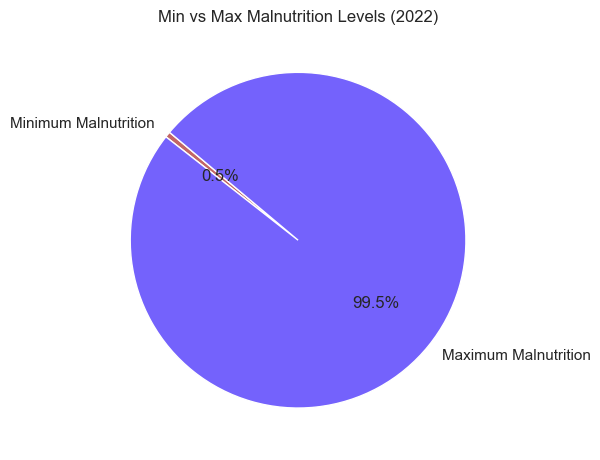

In [103]:
plt.figure(figsize=(6,6))

plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=["#c26666", "#7462fc"]
)

plt.title(
    f"Min vs Max Malnutrition Levels ({int(df_q9.loc[0,'Year'])})"
)

plt.tight_layout()
plt.show()

In [104]:
# Query 10: High CI_Width flags (CI_Width > 5)

q10 = """
SELECT
    Country,
    Year,
    CI_Width
FROM malnutrition_powerbi
WHERE CI_Width > 5
ORDER BY CI_Width DESC;
"""

df_q10 = pd.read_sql(q10, conn)
df_q10.head()

,Country,Year,CI_Width
0,Senegal,2022,26.701744
1,Senegal,2022,26.701744
2,Senegal,2021,25.679344
3,Senegal,2021,25.679344
4,Senegal,2020,24.586366


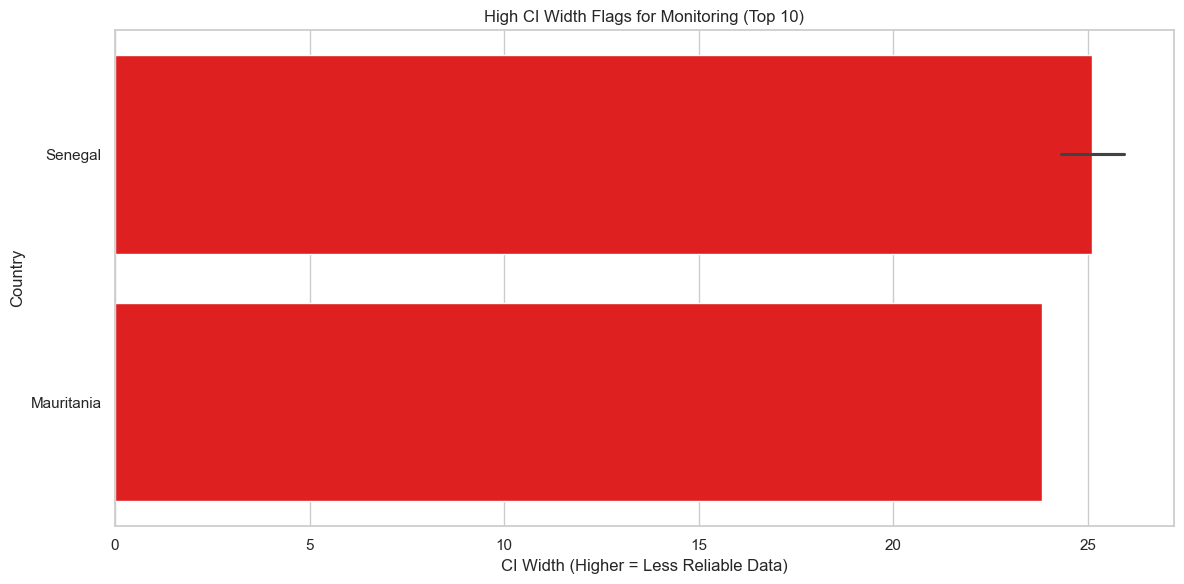

In [106]:
# Take top 10 highest CI_Width for clarity
df_q10_plot = df_q10.sort_values("CI_Width", ascending=False).head(10)

plt.figure(figsize=(12,6))

sns.barplot(
    data=df_q10_plot,
    x="CI_Width",
    y="Country",
    color="red"
)

plt.title("High CI Width Flags for Monitoring (Top 10)")
plt.xlabel("CI Width (Higher = Less Reliable Data)")
plt.ylabel("Country")

plt.tight_layout()
plt.show()

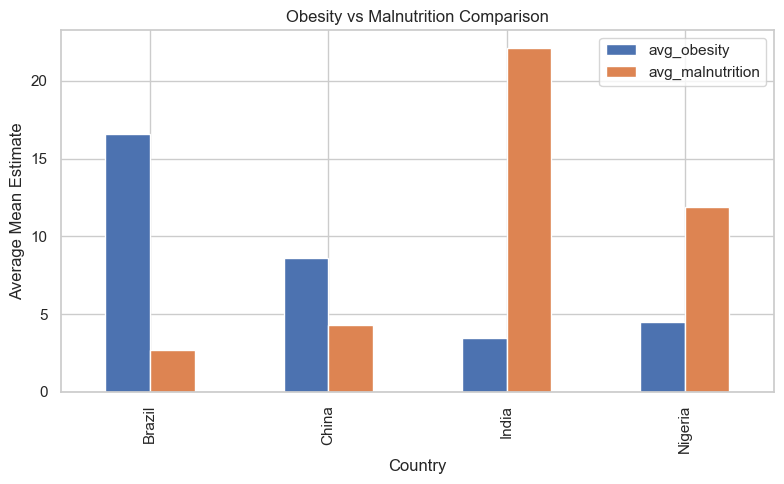

In [107]:
#Combined query
     

# Combined Query 1: Obesity vs Malnutrition comparison by country

q_c1 = """
SELECT
    o.Country,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
WHERE o.Country IN ('India','USA','Brazil','Nigeria','China')
GROUP BY o.Country;
"""

df_c1 = pd.read_sql(q_c1, conn)

df_c1.plot(
    x="Country",
    kind="bar",
    figsize=(8,5),
    title="Obesity vs Malnutrition Comparison"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()


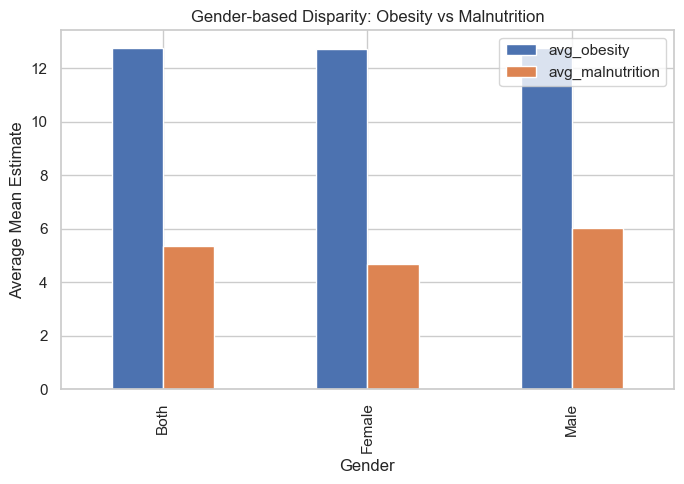

In [108]:
# Combined Query 2 (FIXED): Gender-based disparity in both obesity and malnutrition

q_c2 = """
SELECT
    o.Gender AS Gender,
    AVG(o.Mean_Estimate) AS avg_obesity,
    AVG(m.mean_estimate) AS avg_malnutrition
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
ON o.Country = m.Country
AND o.Year = m.Year
AND o.Gender = m.Gender
GROUP BY o.Gender;
"""

df_c2 = pd.read_sql(q_c2, conn)

df_c2.plot(
    x="Gender",
    kind="bar",
    figsize=(7,5),
    title="Gender-based Disparity: Obesity vs Malnutrition"
)

plt.ylabel("Average Mean Estimate")
plt.tight_layout()
plt.show()

In [109]:
# Combined Query 3: Region-wise average estimates (Africa vs Americas)

q_c3 = """
SELECT
    Region,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Region IN ('Africa', 'Americas')
GROUP BY Region;
"""

df_region = pd.read_sql(q_c3, conn)
df_region

,Region,avg_obesity
0,Africa,5.415204
1,Americas,18.402103


In [110]:
# Get country-wise data for Africa & Americas

q_map_region = """
SELECT
    Country,
    Region,
    AVG(Mean_Estimate) AS avg_obesity
FROM obesity_powerbi
WHERE Region IN ('Africa', 'Americas')
GROUP BY Country, Region;
"""

df_map_region = pd.read_sql(q_map_region, conn)
df_map_region.head()


,Country,Region,avg_obesity
0,Algeria,Africa,15.051907
1,Angola,Africa,4.758767
2,Antigua and Barbuda,Americas,24.229991
3,Argentina,Americas,19.447073
4,Bahamas,Americas,29.402310


In [111]:
fig = px.choropleth(
    df_map_region,
    locations="Country",
    locationmode="country names",
    color="avg_obesity",
    facet_col="Region",                 
    color_continuous_scale="OrRd",
    title="Region-wise Average Obesity Levels: Africa vs Americas",
    labels={"avg_obesity": "Average Obesity (%)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title="Obesity %")
)

fig.show()

In [117]:
# Combined Query 4: Obesity up & malnutrition down

q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.mean_estimate) - MIN(m.mean_estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0 AND malnutrition_change < 0;
"""

df_c4 = pd.read_sql(q_c4, conn)
df_c4.head()


,Country,obesity_change,malnutrition_change


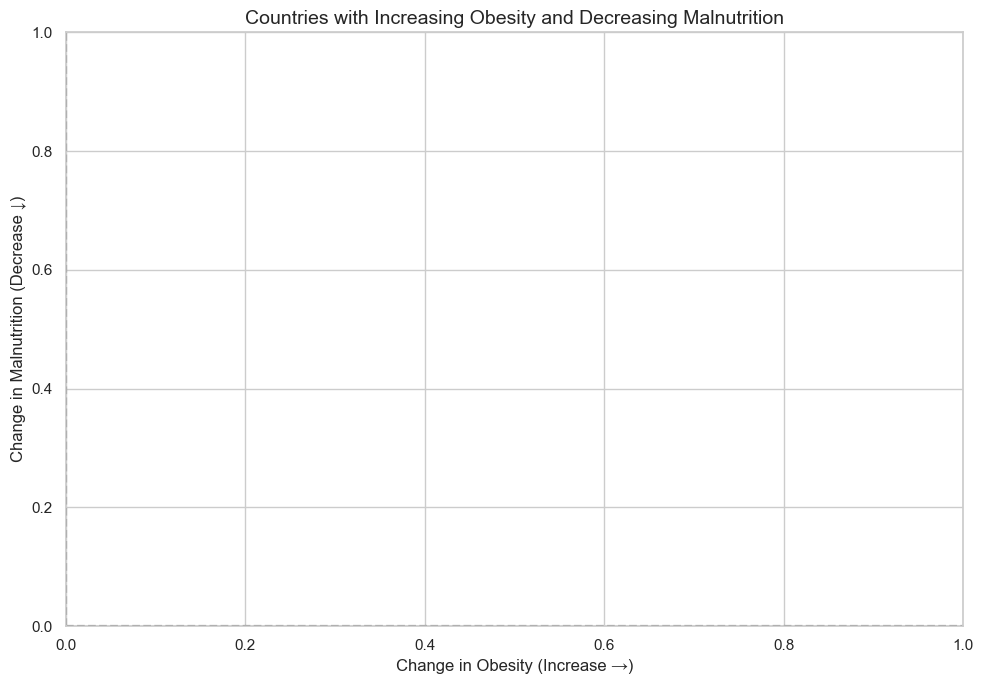

In [118]:

# Combined Query 4: Obesity up & malnutrition down

plt.figure(figsize=(10,7))

sns.scatterplot(
    data=df_c4,
    x="obesity_change",
    y="malnutrition_change",
    s=100,
    color="purple"
)

# Quadrant reference lines
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")

plt.title(
    "Countries with Increasing Obesity and Decreasing Malnutrition",
    fontsize=14
)

plt.xlabel("Change in Obesity (Increase →)")
plt.ylabel("Change in Malnutrition (Decrease ↓)")

plt.tight_layout()
plt.show()



In [119]:
df_c4.shape

(0, 3)

In [120]:
#debug view for Combined Query 4
q_c4 = """
SELECT
    o.Country,
    (MAX(o.Mean_Estimate) - MIN(o.Mean_Estimate)) AS obesity_change,
    (MAX(m.mean_estimate) - MIN(m.mean_estimate)) AS malnutrition_change
FROM obesity_powerbi o
JOIN malnutrition_powerbi m
    ON o.Country = m.Country
GROUP BY o.Country
HAVING obesity_change > 0
ORDER BY obesity_change DESC
LIMIT 15;
"""

df_c4 = pd.read_sql(q_c4, conn)
df_c4


,Country,obesity_change,malnutrition_change
0,American Samoa,69.872773,0.900433
1,Tonga,61.650150,0.893908
2,Samoa,61.579215,1.472992
3,Nauru,57.511939,1.448612
4,Tuvalu,57.412850,3.026137
5,Tokelau,57.103929,1.272598
6,Cook Islands,56.728450,1.187258
7,Niue,51.542111,0.896485
8,Kiribati,48.586033,1.458298
9,Marshall Islands,48.244784,3.399414


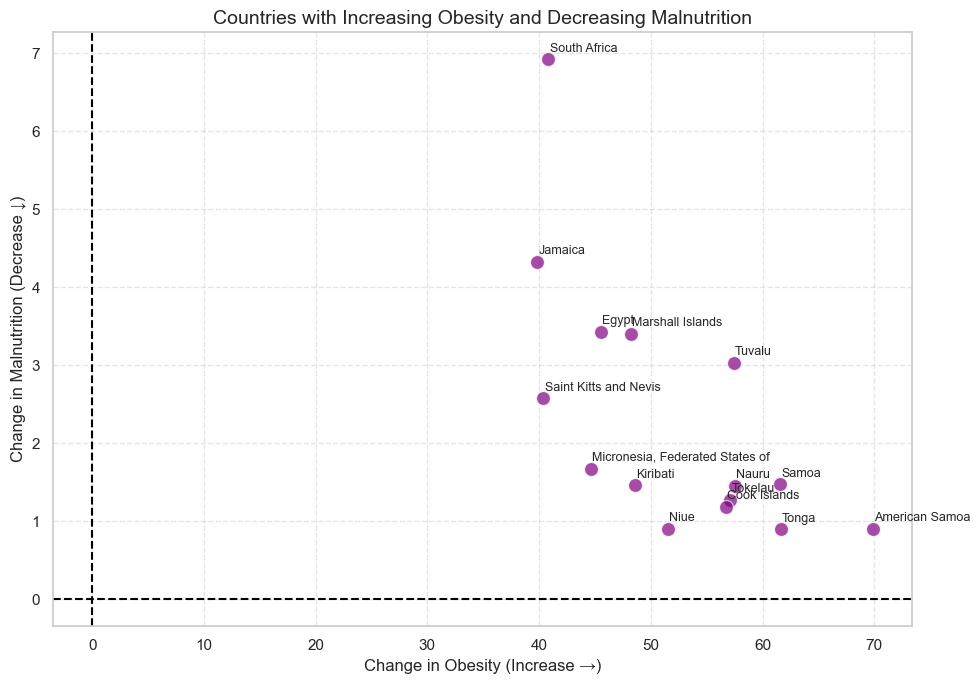

In [122]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_c4,
    x="obesity_change",
    y="malnutrition_change",
    s=100,
    color="purple",
    alpha=0.7
)

plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")

# Annotate countries
for i, row in df_c4.iterrows():
    plt.text(row["obesity_change"] + 0.1, row["malnutrition_change"] + 0.1, row["Country"], fontsize=9)

plt.title("Countries with Increasing Obesity and Decreasing Malnutrition", fontsize=14)
plt.xlabel("Change in Obesity (Increase →)")
plt.ylabel("Change in Malnutrition (Decrease ↓)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


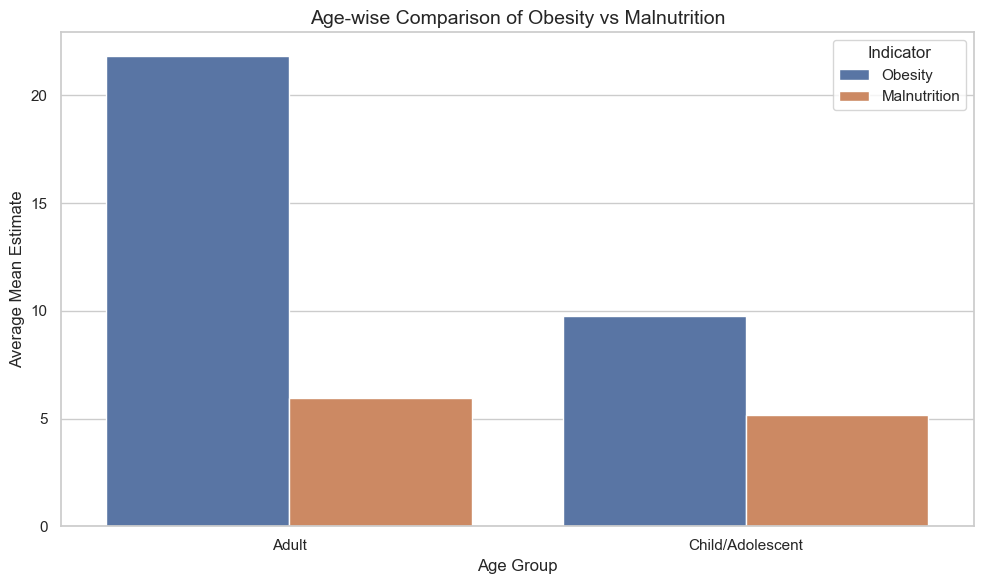

In [125]:
#Combined Query 5: Age-wise trend analysis


# ---- Prepare Obesity data ----
obesity_age = (
    df_obesity
    .groupby("Age_Group")["Mean_Estimate"]
    .mean()
    .reset_index()
)
obesity_age["Type"] = "Obesity"

# ---- Prepare Malnutrition data ----
malnutrition_age = (
    df_malnutrition
    .groupby("Age_Group")["Mean_Estimate"]
    .mean()
    .reset_index()
)
malnutrition_age["Type"] = "Malnutrition"

# ---- Combine ----
combined_age = pd.concat([obesity_age, malnutrition_age])

# ---- Plot (Grouped Bar Chart) ----
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined_age,
    x="Age_Group",
    y="Mean_Estimate",
    hue="Type"
)

plt.title("Age-wise Comparison of Obesity vs Malnutrition", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Average Mean Estimate")
plt.legend(title="Indicator")
plt.tight_layout()
plt.show()